In [1]:
import pandas as pd 
df_universalis = pd.read_csv("/media/jbulkatravail/DATA2/JB_HD/Thèse/Coffre Fort Thèse/XP_thèse/Classification/Données/data_universalis.csv",
index_col=0)
import joblib

df_wiki = joblib.load("/media/jbulkatravail/DATA2/JB_HD/Thèse/Coffre Fort Thèse/XP_thèse/Classification/Notebooks/data/df_wiki.joblib")
from tqdm import tqdm 

df_wiki = pd.DataFrame([df.mean(0) for df in tqdm(df_wiki)])
pos = [x.split("POS -")[1] for x in df_wiki.columns if "POS" in x]
df_wiki.columns = [x if not "POS" in x else x.split("POS -")[1] for x in df_wiki.columns]

df_universalis.fillna(0, inplace=True)
df_wiki.fillna(0, inplace=True)

100%|██████████| 1841/1841 [00:01<00:00, 979.60it/s] 


In [2]:
columns = [x for x in df_wiki.columns if x in df_universalis.columns]
df_wiki = df_wiki.loc[:,columns]
df_universalis = df_universalis.loc[:,columns]

for sub_cat in ["Tense","Gender","Number","Mood","VerbForm","POS"]:
    if sub_cat == "POS":
        current_cols = pos 
    else:
        current_cols = [x for x in columns if ((sub_cat in x) and (not "[]" in x))]
    row_sums = df_wiki.loc[:,current_cols].sum(axis=1)
    # Divide each cell by its row sum
    df_wiki.loc[:,current_cols] = df_wiki.loc[:,current_cols].div(row_sums, axis=0)

    row_sums = df_universalis.loc[:,current_cols].sum(axis=1)
    # Divide each cell by its row sum
    df_universalis.loc[:,current_cols] = df_universalis.loc[:,current_cols].div(row_sums, axis=0)
    #df_wiki.loc[:,[x for x in columns if sub_cat in x]] = df_wiki.loc[:,[x for x in columns if sub_cat in x]]/df_wiki.loc[:,[x for x in columns if sub_cat in x]] 
#effect_size_distribution(df_wiki.to_numpy()[:,:],
#                         df_universalis.to_numpy()[:,:],
#                         columns=columns[:])

columns = [x for x in df_wiki.columns if ((not '[]' in x) or ("Voice" in x ))]
df_wiki = df_wiki.loc[:,columns]
df_universalis = df_universalis.loc[:,columns]
df_wiki["y"] = 1
df_universalis["y"] = 0

In [8]:
X = pd.concat((df_universalis, df_wiki),axis=0)
X.fillna(0, inplace=True)
X, y = X.iloc[:,:-1], X.iloc[:,-1]

In [42]:
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform, randint
from sklearn.metrics import balanced_accuracy_score

pipe_LR = Pipeline([("scaler", StandardScaler()),
                 ("decomposition", PCA()),
                 ("classification", LogisticRegression(penalty="l2"))])

dict_parameters_LR = {"decomposition__n_components" : randint(2,5),
                    "classification__C" : uniform(1,5)}

LR_search = RandomizedSearchCV(pipe_LR, 
                                   param_distributions=dict_parameters_LR,
                                   scoring="balanced_accuracy",
                                   verbose=4,
                                   n_iter=25)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,shuffle=True, stratify=y)

LR_search.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END classification__C=2.0218264981347627, decomposition__n_components=2;, score=1.000 total time=   0.1s
[CV 2/5] END classification__C=2.0218264981347627, decomposition__n_components=2;, score=0.997 total time=   0.1s
[CV 3/5] END classification__C=2.0218264981347627, decomposition__n_components=2;, score=1.000 total time=   0.1s
[CV 4/5] END classification__C=2.0218264981347627, decomposition__n_components=2;, score=0.996 total time=   0.1s
[CV 5/5] END classification__C=2.0218264981347627, decomposition__n_components=2;, score=0.998 total time=   0.1s
[CV 1/5] END classification__C=2.0732780027082263, decomposition__n_components=2;, score=1.000 total time=   0.1s
[CV 2/5] END classification__C=2.0732780027082263, decomposition__n_components=2;, score=0.997 total time=   0.1s
[CV 3/5] END classification__C=2.0732780027082263, decomposition__n_components=2;, score=1.000 total time=   0.1s
[CV 4/5] END classificatio

,estimator,Pipeline(step...egression())])
,param_distributions,"{'classification__C': <scipy.stats....x724aa45722d0>, 'decomposition__n_components': <scipy.stats....x724aa455b5c0>}"
,n_iter,25
,scoring,'balanced_accuracy'
,n_jobs,None
,refit,True
,cv,None
,verbose,4
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [30]:
prediction = LR_search.best_estimator_.predict(X_test)
balanced_accuracy_score(y_test, prediction)

1.0

In [19]:
import numpy as np 

components_0 = LR_search.best_estimator_["decomposition"].components_[0]

print(np.array(columns)[np.argsort(components_0)[::-1]][:10])
print(components_0[np.argsort(components_0)[::-1]][:10])

['div_tok' 'div_mot' 'VERB' 'NOUN' "Voice : ['Pass']" 'AUX' 'PROPN'
 "Person : ['3']" 'NUM' 'X']
[0.37616665 0.35134923 0.28818255 0.22796916 0.21205245 0.15017683
 0.14408681 0.14310427 0.13777951 0.10469016]


In [29]:
components_1 = LR_search.best_estimator_["decomposition"].components_[1]

print(np.array(columns)[np.argsort(np.abs(components_1))[::-1]][:10])
print(components_1[np.argsort(np.abs(components_1))[::-1]][:10])

['ADV' "Person : ['3']" "Tense : ['Past']" "VerbForm : ['Part']"
 "Tense : ['Pres']" 'PROPN' 'SCONJ' 'NUM' 'ADP' 'ADJ']
[ 0.30321726  0.29771953 -0.28590499 -0.28341782  0.24240572 -0.23098894
  0.22522908 -0.21637874 -0.21156108  0.18444452]


In [45]:
components_1 = LR_search.best_estimator_["decomposition"].components_[3]

print(np.array(columns)[np.argsort(np.abs(components_1))[::-1]][:10])
print(components_1[np.argsort(np.abs(components_1))[::-1]][:10])

['PRON' "Tense : ['Pres']" 'SCONJ' 'ADJ' 'NOUN' 'VERB' "Mood : ['Ind']"
 "Tense : ['Imp']" "Number : ['Sing']" "Number : ['Plur']"]
[ 0.30493027 -0.27377901  0.24761854 -0.23783615 -0.23086286  0.22634345
 -0.22460977  0.21902158  0.20725242 -0.20725242]


In [53]:
components_1 = LR_search.best_estimator_["decomposition"].components_[0]

print(np.array(columns)[np.argsort(np.abs(components_1))[::-1]][:20])
print(components_1[np.argsort(np.abs(components_1))[::-1]][:20])

['div_tok' 'DET' 'div_mot' 'ADP' 'VERB' 'CCONJ' 'NOUN' 'Voice : []'
 "Voice : ['Pass']" 'PRON' 'AUX' 'PROPN' "Person : ['3']" 'SCONJ' 'NUM'
 "VerbForm : ['Part']" 'X' "VerbForm : ['Inf']" "Gender : ['Fem']"
 "Gender : ['Masc']"]
[ 0.37575203 -0.35888219  0.35119055 -0.32266431  0.28920852 -0.25922366
  0.22702073 -0.21439597  0.21439597 -0.20465323  0.1480408   0.14605931
  0.14274409 -0.14067555  0.13944085  0.1043929   0.10105993 -0.08547145
 -0.08244933  0.08244933]


In [43]:
LR_search.best_estimator_["classification"].coef_

array([[ 2.66410533,  0.93653454,  0.23521626, -1.59112065]])

In [39]:
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform, randint
from sklearn.metrics import balanced_accuracy_score

pipe_LR = Pipeline([("scaler", StandardScaler()),
                 #("decomposition", PCA()),
                 ("classification", LogisticRegression(penalty="l2"))])

dict_parameters_LR = {#"decomposition__n_components" : randint(3,15),
                    "classification__C" : uniform(1,5)}

LR_search_noPCA = RandomizedSearchCV(pipe_LR, 
                                   param_distributions=dict_parameters_LR,
                                   scoring="balanced_accuracy",
                                   verbose=4,
                                   n_iter=25)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,shuffle=True, stratify=y)

LR_search_noPCA.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END classification__C=2.2683161879775193;, score=1.000 total time=   0.4s
[CV 2/5] END classification__C=2.2683161879775193;, score=1.000 total time=   0.3s
[CV 3/5] END classification__C=2.2683161879775193;, score=1.000 total time=   0.2s
[CV 4/5] END classification__C=2.2683161879775193;, score=1.000 total time=   0.2s
[CV 5/5] END classification__C=2.2683161879775193;, score=1.000 total time=   0.2s
[CV 1/5] END classification__C=5.0934631821133385;, score=1.000 total time=   0.2s
[CV 2/5] END classification__C=5.0934631821133385;, score=1.000 total time=   0.3s
[CV 3/5] END classification__C=5.0934631821133385;, score=1.000 total time=   0.2s
[CV 4/5] END classification__C=5.0934631821133385;, score=1.000 total time=   0.3s
[CV 5/5] END classification__C=5.0934631821133385;, score=1.000 total time=   0.2s
[CV 1/5] END classification__C=3.34473801620076;, score=1.000 total time=   0.2s
[CV 2/5] END classification

,estimator,Pipeline(step...egression())])
,param_distributions,{'classification__C': <scipy.stats....x724aa2f62c60>}
,n_iter,25
,scoring,'balanced_accuracy'
,n_jobs,None
,refit,True
,cv,None
,verbose,4
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [49]:
coefs

array([[ 0.15774412,  0.257109  , -1.18171129,  0.88880757,  0.2008265 ,
         0.45017461,  0.23879047,  0.55756001,  0.52538009,  0.36170906,
        -1.00520581,  0.34835717, -0.5401992 ,  0.03354818, -0.27215644,
        -0.35022051,  0.13791718,  0.07078551,  0.2542299 ,  0.74736964,
         0.11963302,  0.1011035 ,  0.0668335 ,  0.08513835,  0.08341815,
        -0.08341815, -0.15106339,  0.15106339,  0.02630922, -0.25955931,
         0.30753244,  0.36047889, -0.36047889,  0.0049539 ,  0.14595273,
         0.03381377, -0.01770269]])

In [51]:
coefs = LR_search_noPCA.best_estimator_["classification"].coef_

print(np.array(columns)[np.argsort(np.abs(coefs[0]))[::-1]])
print(coefs[:,np.argsort(np.abs(coefs[0]))[::-1]])

['DET' 'ADP' 'NOUN' "Person : ['3']" 'AUX' 'PRON' 'ADJ' 'NUM' 'X'
 "Voice : ['Pass']" 'Voice : []' "Tense : ['Past']" 'ADV'
 "VerbForm : ['Inf']" 'CCONJ' "VerbForm : ['Fin']" 'div_tok'
 "Tense : ['Imp']" 'VERB' 'PROPN' 'div_mot' "Number : ['Plur']"
 "Number : ['Sing']" "Person : ['2']" "Tense : ['Pres']" "Person : ['1']"
 "Mood : ['Ind']" "Mood : ['Sub']" "Gender : ['Fem']" "Gender : ['Masc']"
 "Tense : ['Fut']" "Mood : ['Cnd']" 'INTJ' 'SCONJ' "VerbForm : ['Part']"
 "Mood : ['Imp']" 'SYM']
[[-1.18171129 -1.00520581  0.88880757  0.74736964  0.55756001 -0.5401992
   0.52538009  0.45017461  0.36170906 -0.36047889  0.36047889 -0.35022051
   0.34835717  0.30753244 -0.27215644 -0.25955931  0.257109    0.2542299
   0.23879047  0.2008265   0.15774412 -0.15106339  0.15106339  0.14595273
   0.13791718  0.11963302  0.1011035   0.08513835 -0.08341815  0.08341815
   0.07078551  0.0668335   0.03381377  0.03354818  0.02630922 -0.01770269
   0.0049539 ]]


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform, randint
from sklearn.metrics import balanced_accuracy_score

pipe_RF = Pipeline([("scaler", StandardScaler()),
                 ("decomposition", PCA()),
                 ("classification", RandomForestClassifier())])

dict_parameters_RF = {"decomposition__n_components" : randint(3,15),
                    "classification__n_estimators" : [25, 50, 75, 100],
                    "classification__criterion" : ["gini","entropy"],
                    "classification__min_samples_leaf" : randint(2,10)}

forest_search = RandomizedSearchCV(pipe_RF, 
                                   param_distributions=dict_parameters_RF,
                                   scoring="balanced_accuracy",
                                   verbose=4)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,shuffle=True, stratify=y)

forest_search.fit(X_train,y_train)

In [ ]:
from sklearn.linear_model import LogisticRegression 

pipe_LR = Pipeline([("scaler", StandardScaler()),
                 ("decomposition", PCA()),
                 ("classification", LogisticRegression())])

dict_parameters_LR = {"decomposition__n_components" : randint(3,15),
                    "classification__C" : uniform(1,5)}

LR_search = RandomizedSearchCV(pipe_LR, 
                                   param_distributions=dict_parameters_LR,
                                   scoring="balanced_accuracy",
                                   verbose=4,
                                   n_iter=25)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,shuffle=True, stratify=y)

LR_search.fit(X_train,y_train)

In [54]:
y.mean()

np.float64(0.047798317582303455)

In [56]:
columns

['div_mot',
 'div_tok',
 'DET',
 'NOUN',
 'PROPN',
 'NUM',
 'VERB',
 'AUX',
 'ADJ',
 'X',
 'ADP',
 'ADV',
 'PRON',
 'SCONJ',
 'CCONJ',
 "Tense : ['Past']",
 "Tense : ['Pres']",
 "Tense : ['Fut']",
 "Tense : ['Imp']",
 "Person : ['3']",
 "Person : ['1']",
 "Mood : ['Ind']",
 "Mood : ['Cnd']",
 "Mood : ['Sub']",
 "Gender : ['Masc']",
 "Gender : ['Fem']",
 "Number : ['Plur']",
 "Number : ['Sing']",
 "VerbForm : ['Part']",
 "VerbForm : ['Fin']",
 "VerbForm : ['Inf']",
 'Voice : []',
 "Voice : ['Pass']",
 'SYM',
 "Person : ['2']",
 'INTJ',
 "Mood : ['Imp']"]

<Axes: >

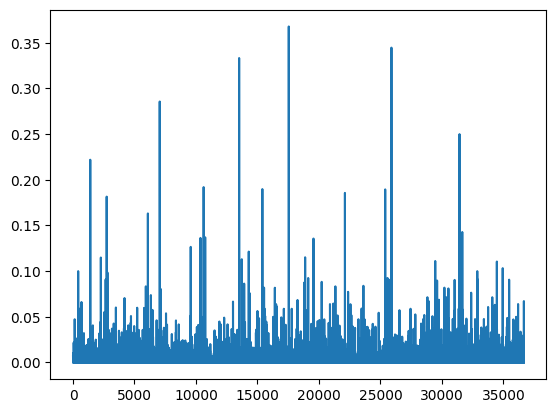

In [59]:
X[y==0].loc[:,"Mood : ['Imp']"].plot()

In [55]:
X[y==0,np.array(columns)=="Mood : ['Imp']"]

InvalidIndexError: (0        True
1        True
2        True
3        True
4        True
        ...  
1836    False
1837    False
1838    False
1839    False
1840    False
Name: y, Length: 38516, dtype: bool, array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True]))